# PHYS 576 HW 1
### Joshua LaBounty
### 10/2/2018

This notebook will be used to complete the assignment detailed here: https://canvas.uw.edu/courses/1224622/files?preview=50937030 and here ./pdf/hw1.pdf

In [2]:
#General imports.
import ROOT as r
import math
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1111)
import matplotlib.pyplot as plt
import csv
import pandas

import seaborn as sns
sns.set(style="ticks", color_codes=True)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
import os
import scipy

%matplotlib inline

Welcome to JupyROOT 6.12/06


You can work through this problem set however you like. Jupyter notebooks, matlab, analytic calculations, etc. But please document your thinking clearly in words and plots, as well as coming up with an answer. For the first few problems we’re going to play with a Poisson distribution. Tools for throwing random poisson distributions and calculating cumulative probability functions can be found in scipy.stats or matlab’s Statistics and Machine Learning Toolbox.

So let’s imagine that we have an experiment that counts events, and the average number of events is well determined to be 50.1. You can imagine this as something that counts radiative decays, with a background decay rate of 50.1 in your measurement interval. Or it could be counting cosmic rays coming from a particular direction on the sky.

1) Simulate what this distribution will look like, and plot on a semilogy histogram plot. 1e4 or 1e5 points should be fine. This is a set of realizations of the background.

In [3]:
#Lets generate a random Poisson distribution with a mean of 50.1, and N = 1e7
nPoints = 10**7
mean = 50.1

testPoisson = scipy.stats.poisson.rvs(mean, size=nPoints)

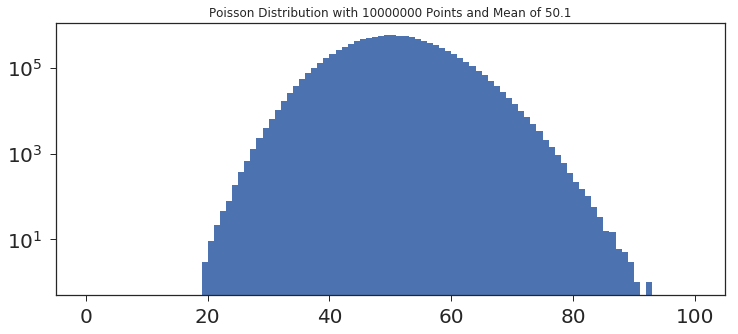

In [4]:
#Now lets plot this and make sure it has been generated correctly
fig, ax = plt.subplots(figsize=(12, 5))
plt.hist(testPoisson,log=True,bins=100,range=(0,100))
plt.title("Poisson Distribution with "+str(nPoints)+" Points and Mean of "+str(mean))
plt.show()

In [5]:
#Now lets also turn this into a root histogram for easy fitting
h1 = r.TH1D("h1","Poisson Distribution with "+str(nPoints)+" Points and Mean of "+str(mean)+";Measured Number of Counts;N",1000,0,100)
for ding in testPoisson:
    h1.Fill(ding)
    
#Normalize the histogram so that the PDF works as advertized
h1.Scale(1/(h1.GetEntries()))

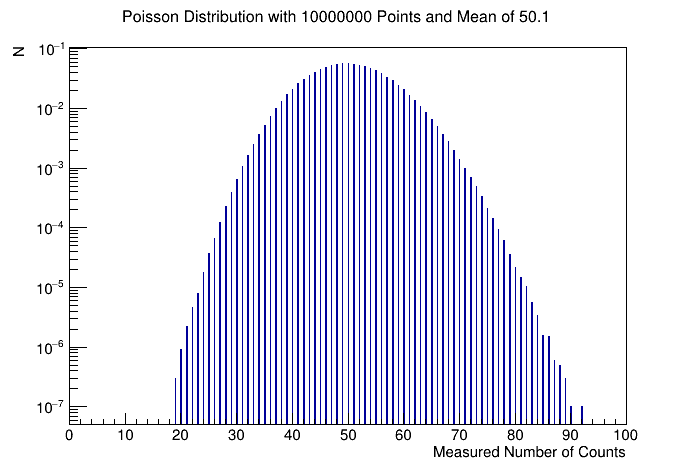

In [6]:
c1 = r.TCanvas()
c1.SetLogy()

h1.Draw("HIST")

c1.Draw()

---


2) Turn your measurements of the background into a measured probability distribution. The
result should integrate to 1.

Reduced ChiSq: 1.0527470011882372
Prob: 0.35768392902506446
 FCN=74.745 FROM MINOS     STATUS=SUCCESSFUL     12 CALLS          89 TOTAL
                     EDM=8.45285e-17    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Normalization   9.99993e-01   3.16227e-04  -1.00281e-07  -4.93770e-07
   2  Mean         5.01463e+01   2.23751e-03   2.23751e-03   8.00675e-04


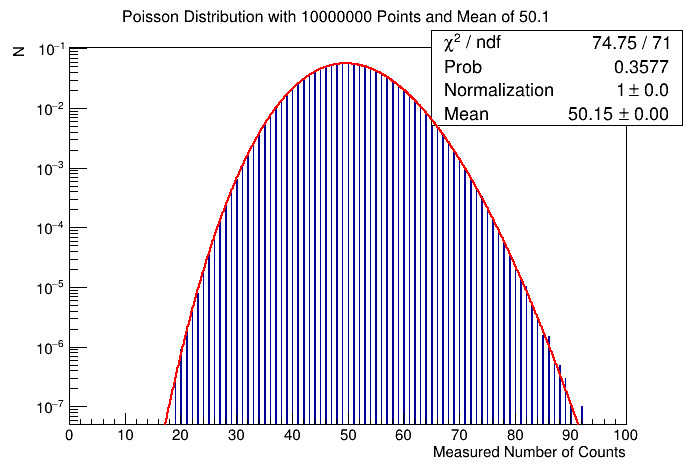

In [7]:
#Now lets put that TH1 to good use and fit this data with a poisson distribution 
#We're cheating a bit here by 'knowing' that we should use a Poisson distribution, 
    #and not comparing the results with other PDF's

def peak_fit(x, p):
    return p[0]*r.TMath.Poisson(x[0],p[1])

func1 = r.TF1("poisson", peak_fit, 0,100,2)
func1.SetParNames('Normalization','Mean')
func1.SetParameters(1,50)
func1.SetLineColor(2)
func1.SetNpx(1000)

for i in range(2): #run fit twice to first get better initial guess, then get actual fit
    if i < 1:
        h1.Fit("poisson","REMQ")
    else:
        h1.Fit("poisson","REM")
func1.Draw("SAME")
c1.Update()
c1.Draw()

chiSq = ( ( func1.GetNDF(),
              func1.GetChisquare(),
              func1.GetProb() ) )

print("Reduced ChiSq:",chiSq[1] / chiSq[0])
print("Prob:", chiSq[2])

In [8]:
#check that this integrates to 1
func1.Integral(-10,100000)

0.9999927967515393

In [9]:
#Looks good enough for me.

---


3) Now imagine that you are looking for a source (something that will add signal counts to your
background), and you measure 80 events. What is the probability of your detection? [Hint: your
simulation does not have enough realizations, so an analytic calculation is needed.]

In [10]:
#We can calculate this from the python built in poisson function
measuredCounts = 80
print("Probability of measurement of", measuredCounts, "is", scipy.stats.poisson.pmf(measuredCounts, mean)*100,"%")

Probability of measurement of 80 is 0.0023666650837525886 %


---


4) Now imagine you are looking for a sink (something that blocks the background). For cosmic
rays the moon is a great example as it blocks celestial cosmic rays and appears as a hole in
the sky. If you measure 30 events what is the probability of your detection?

In [11]:
#Again, calculating from the built in posson function:
measuredCounts = 30
print("Probability of measurement of", measuredCounts, "is", scipy.stats.poisson.pmf(measuredCounts, mean)*100,"%")

Probability of measurement of 30 is 0.0650606140274299 %


---


5) Convert your answers from 3 & 4 into ‘sigma’. 

To convert these into sigma, we can compute the sum from our point of interest to infinity (in the case of 80 counts) or to zero (in the case of 30)

In [12]:
sum30 = 0.00
for i in range(31):
    sum30 += scipy.stats.poisson.pmf(i, mean)
print("The probability of measuring </= 30 counts is",sum30)

sum80 = 1.00
for i in range(80):
    sum80 -= scipy.stats.poisson.pmf(i, mean)
print("The probability of measuring > 80 counts is",sum80)

The probability of measuring </= 30 counts is 0.0015276453034054178
The probability of measuring > 80 counts is 6.032233897295182e-05


---


6) Note that both the signals 3 & 4 were about the same distance from the mean. Did they have
the same significance? Explain/discuss.

No, these do not have the same significance. You are more likely to get smaller than average numbers of counts with the poisson distribution than you are to get larger numbers at the same distance from the mean.

---


For the next few problems, we are imagining that we are concerned with the length of a vector,
where the measurements of both coordinates are independent. To simulate this start with two
Gaussian random variables A & B, both with zero mean and the same variance, then calculate
realizations of the magnitude measurement.

7) Plot the resulting magnitude pdf.

In [13]:
#Lets first generate two ransom gaussian distributions, which will be the vectors of x and y coordinates
nPoints = 1000000
vecX = np.random.normal(0,1,size=nPoints)
vecY = np.random.normal(0,1,size=nPoints)

vecLength = []
for i in range(len(vecX)):
    vecLength.append( np.sqrt(vecX[i]**2 + vecY[i]**2 ) )

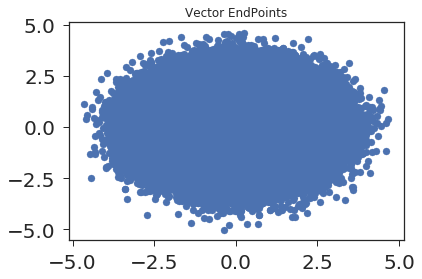

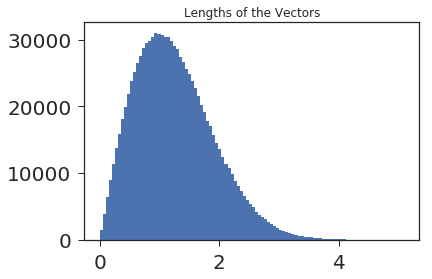

In [14]:
plt.scatter(vecX,vecY)
plt.title("Vector EndPoints")
plt.show()

plt.hist(vecLength,bins=100)
plt.title("Lengths of the Vectors")
plt.show()

Normalizing this final plot, we arrive at the PDF

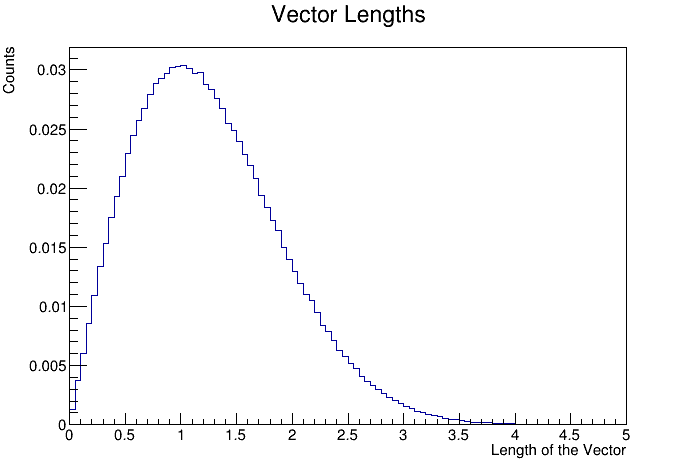

In [15]:
h2 = r.TH1D("h2","Vector Lengths",100,0,5)
for i in vecLength:
    h2.Fill(i)
    
h2.Scale(1/(h2.GetEntries()))
h2.GetXaxis().SetTitle("Length of the Vector")
h2.GetYaxis().SetTitle("Counts")

c2 = r.TCanvas()
h2.Draw("HIST")
c2.Draw()

---

8) Now make the variance of one of the variables much larger than the other, and replot the
magnitude pdf.

We employ the same strategy as above:

In [16]:
vecYLarge = np.random.normal(0,10,size=nPoints)
vecLength2 = []
for i in range(len(vecX)):
    vecLength2.append( np.sqrt(vecX[i]**2 + vecYLarge[i]**2 ) )

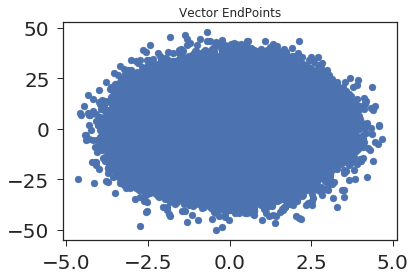

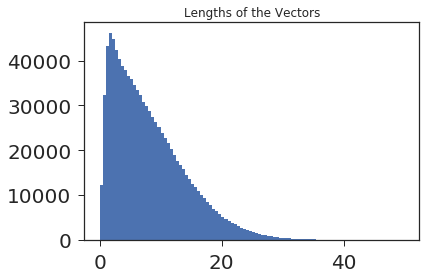

In [17]:
plt.scatter(vecX,vecYLarge)
plt.title("Vector EndPoints")
plt.show()

plt.hist(vecLength2,bins=100)
plt.title("Lengths of the Vectors")
plt.show()

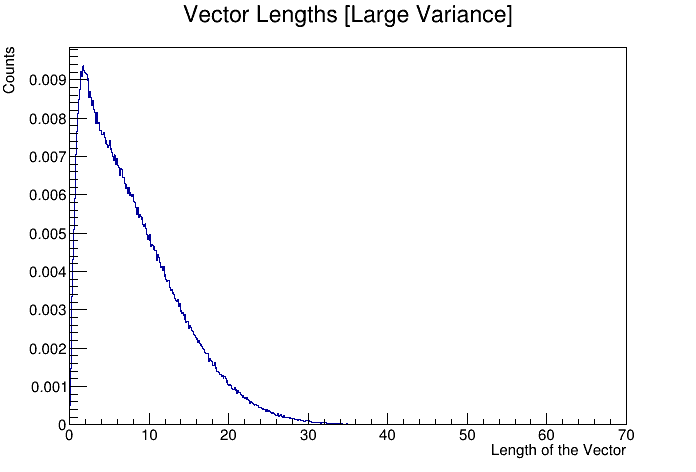

In [18]:
h3 = r.TH1D("h3","Vector Lengths [Large Variance]",700,0,70)
for i in vecLength2:
    h3.Fill(i)
    
h3.Scale(1/(h3.GetEntries()))
h3.GetXaxis().SetTitle("Length of the Vector")
h3.GetYaxis().SetTitle("Counts")

c2 = r.TCanvas()
h3.Draw("HIST")
c2.Draw()

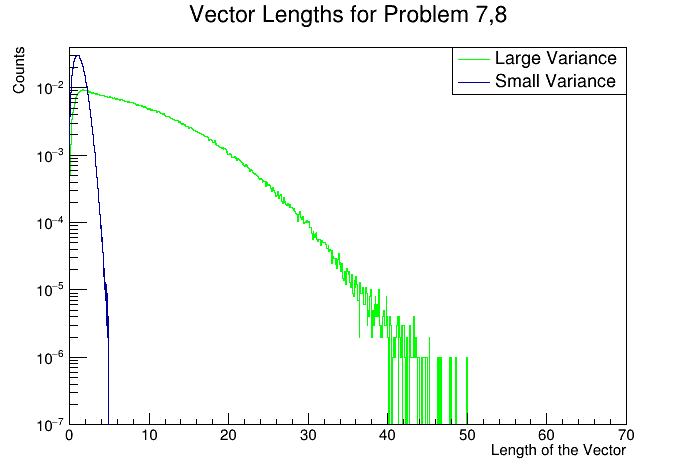

In [19]:
c3 = r.TCanvas()
h3.Draw("HIST")
h3.SetTitle("Vector Lengths for Problem 7,8")
h3.GetXaxis().SetTitle("Length of the Vector")
h3.GetYaxis().SetTitle("Counts")
h3.SetLineColor(3)
h2.Draw("HIST SAME")
h3.GetYaxis().SetRangeUser(0.0000001,.04)

leg = r.TLegend(0.65,0.8,0.9,0.9)
leg.AddEntry(h3 ,"Large Variance", "l")
leg.AddEntry(h2 ,"Small Variance", "l")
leg.Draw()

c3.SetLogy()

c3.Draw()

---


9) Now let’s use the result of 8 as the basis for a different problem. In this case you can
measure the full vector. Create a 2D histogram of the simulation from 8 (axis are length of A & B
respectively).

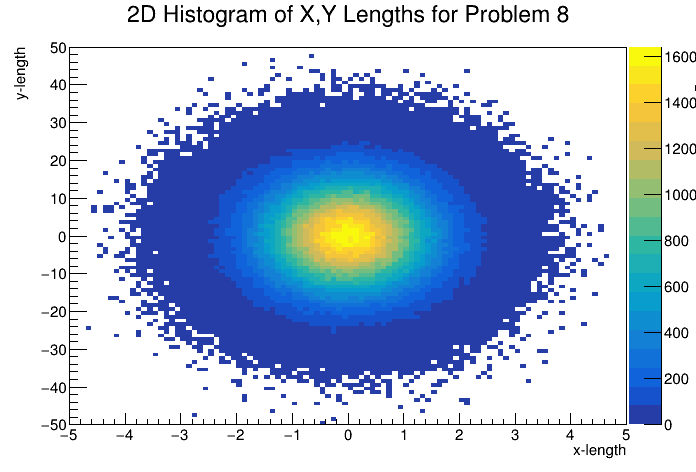

In [20]:
h4 = r.TH2D("h4","2D Histogram of X,Y Lengths for Problem 8",100,-5,5,100,-50,50)
for i in range(len(vecLength2)):
    h4.Fill(vecX[i],vecYLarge[i])
    
h4.GetXaxis().SetTitle("x-length")
h4.GetYaxis().SetTitle("y-length")
h4.GetZaxis().SetTitle("Counts")
c4 = r.TCanvas()
h4.Draw("COLZ")
c4.Draw()

---

Two brain teasers (no need to turn in)

10) Think about how one would extend the idea of ‘more signal like’ from problems 3 & 4 to this
two dimensional example. You have the answer for a magnitude. What if the signal had a
particular direction in the AB plane?

11) In problem 3 your simulations did not have enough throws to calculate the significance.
How many throws would be needed for the simulated background to accurately determine the
significance in this case?